This notebook analyzes every boxscore for every NBA team going back to the 1996 season (beginning of advanced metrics tracking) to identify which metrics are most predictive of winning games. We employ multiple machine learning models and feature importance techniques to provide a comprehensive ranking of statistics most closely associated with wins.

**Key Questions:**
- Which metrics are most predictive of winning?
- How consistent are these findings across different ML approaches?
- What insights can we derive for team strategy and performance evaluation?


In [6]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import SelectKBest, f_classif, mutual_info_classif
from sklearn.metrics import accuracy_score, classification_report
from sklearn.inspection import permutation_importance
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

In [7]:
plt.style.use('default')
sns.set_palette("husl")

# Load data

In [8]:
def load_team_boxscore_data(file_path):
    """Load and initially explore the basketball dataset"""
    df = pd.read_csv(file_path)
    
    print("Dataset Overview:")
    print(f"Shape: {df.shape}")
    print(f"Columns: {list(df.columns)}")
    print(f"\nFirst few rows:")
    
    return df

In [11]:
df = load_team_boxscore_data('test_datasets/team_boxscore_test_dataset.csv')
df.head()

Dataset Overview:
Shape: (68620, 33)
Columns: ['season', 'date', 'team', 'opp', 'win?', 'min', 'fgm', 'fga', 'fg_pct', 'fg3m', 'fg3a', 'fg3_pct', 'ftm', 'fta', 'ft_pct', 'oreb', 'dreb', 'reb', 'ast', 'stl', 'blk', 'tov', 'pf', 'pts_off_turnovers', 'second_chance_pts', 'fast_break_pts', 'paint_pts', 'opp_pts_off_turnovers', 'opp_second_chance_pts', 'opp_fast_break_pts', 'opp_paint_pts', 'assist_to_turnover', 'pace']

First few rows:


,season,date,team,opp,win?,min,fgm,fga,fg_pct,fg3m,...,pts_off_turnovers,second_chance_pts,fast_break_pts,paint_pts,opp_pts_off_turnovers,opp_second_chance_pts,opp_fast_break_pts,opp_paint_pts,assist_to_turnover,pace
0,1996,1996-11-01,VAN,POR,0,48,34,77,0.442,5,...,20,8,6,34,26,24,19,62,1.44,92.0
1,1996,1996-11-01,SEA,UTA,0,48,30,75,0.400,5,...,16,18,6,38,23,16,13,32,1.33,87.0
2,1996,1996-11-01,DEN,DAL,0,48,28,78,0.359,3,...,19,18,15,28,16,18,9,44,0.62,97.0
3,1996,1996-11-01,DAL,DEN,1,48,35,88,0.398,4,...,16,18,9,44,19,18,15,28,0.95,97.0
4,1996,1996-11-01,SAC,HOU,0,47,32,72,0.444,4,...,20,9,11,37,40,16,20,44,0.66,100.5


In [12]:
print("Win/Loss Distribution:")
print(df['win?'].value_counts())
print(f"Win Rate: {df['win?'].mean():.1%}")

Win/Loss Distribution:
win?
0    34310
1    34310
Name: count, dtype: int64
Win Rate: 50.0%


In [13]:
print(f"\nMissing Values:")
missing_data = df.isnull().sum()
print(missing_data[missing_data > 0] if missing_data.sum() > 0 else "No missing values found")


Missing Values:
No missing values found


## Data Preparation


In [14]:
def prepare_features(df):    
    df_clean = df.copy()
    df_clean['win'] = df_clean['win?'].astype(int)
    
    # Define feature columns (exclude non-predictive variables)
    feature_columns = [
        'fgm', 'fga', 'fg_pct', 'fg3m', 'fg3a', 'fg3_pct',
        'ftm', 'fta', 'ft_pct', 'oreb', 'dreb', 'ast', 'stl',
        'blk', 'tov', 'pf', 'pts_off_turnovers',
        'second_chance_pts', 'fast_break_pts', 'paint_pts',
        'opp_pts_off_turnovers', 'opp_second_chance_pts',
        'opp_fast_break_pts', 'opp_paint_pts', 'assist_to_turnover', 'pace'
    ]
    
    # Create feature matrix and target
    X = df_clean[feature_columns].copy()
    y = df_clean['win'].copy()
    
    # Handle any missing values
    X = X.fillna(X.mean())
    
    print(f"Features prepared: {X.shape[1]} variables")
    print(f"Sample size: {X.shape[0]} games")
    
    return X, y, feature_columns

In [15]:
X, y, feature_names = prepare_features(df)

feature_correlations = X.corrwith(y).abs().sort_values(ascending=False)
print("Top 10 Features by Correlation with Win/Loss:")
print(feature_correlations.head(10).round(3))

Features prepared: 26 variables
Sample size: 68620 games
Top 10 Features by Correlation with Win/Loss:
fg_pct                   0.445
fgm                      0.344
dreb                     0.333
ast                      0.316
fg3_pct                  0.287
assist_to_turnover       0.243
pts_off_turnovers        0.221
opp_pts_off_turnovers    0.221
ftm                      0.166
blk                      0.164
dtype: float64


# Training

In [17]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=1, stratify=y
)

In [18]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [21]:
print(f"Training set: {X_train.shape[0]} observations")
print(f"Test set: {X_test.shape[0]} observations")

Training set: 54896 observations
Test set: 13724 observations


In [22]:
models = {}
results = {}
feature_importance_results = {}

# Random Forest

In [24]:
print("Training Random Forest...")
rf_model = RandomForestClassifier(n_estimators=100, random_state=1, n_jobs=-1)
rf_model.fit(X_train, y_train)

Training Random Forest...


RandomForestClassifier(n_jobs=-1, random_state=1)

In [25]:
rf_pred = rf_model.predict(X_test)
rf_accuracy = accuracy_score(y_test, rf_pred)
rf_cv_score = cross_val_score(rf_model, X_train, y_train, cv=5, n_jobs=-1).mean()

In [26]:
models['Random Forest'] = rf_model
results['Random Forest'] = {
    'accuracy': rf_accuracy,
    'cv_score': rf_cv_score
}
feature_importance_results['Random Forest'] = dict(zip(feature_names, rf_model.feature_importances_))

print(f"Random Forest - Test Accuracy: {rf_accuracy:.4f}, CV Score: {rf_cv_score:.4f}")

Random Forest - Test Accuracy: 0.8425, CV Score: 0.8375


# Gradient Boosting

In [28]:
print("Training Gradient Boosting...")
gb_model = GradientBoostingClassifier(n_estimators=100, random_state=1)
gb_model.fit(X_train, y_train)

Training Gradient Boosting...


GradientBoostingClassifier(random_state=1)

In [29]:
gb_pred = gb_model.predict(X_test)
gb_accuracy = accuracy_score(y_test, gb_pred)
gb_cv_score = cross_val_score(gb_model, X_train, y_train, cv=5).mean()

In [30]:
models['Gradient Boosting'] = gb_model
results['Gradient Boosting'] = {
    'accuracy': gb_accuracy,
    'cv_score': gb_cv_score
}
feature_importance_results['Gradient Boosting'] = dict(zip(feature_names, gb_model.feature_importances_))

print(f"Gradient Boosting - Test Accuracy: {gb_accuracy:.4f}, CV Score: {gb_cv_score:.4f}")

Gradient Boosting - Test Accuracy: 0.8514, CV Score: 0.8470


# Logistic Regression

In [31]:
print("Training Logistic Regression...")
lr_model = LogisticRegression(random_state=1, max_iter=1000)
lr_model.fit(X_train_scaled, y_train)

Training Logistic Regression...


LogisticRegression(max_iter=1000, random_state=1)

In [32]:
lr_pred = lr_model.predict(X_test_scaled)
lr_accuracy = accuracy_score(y_test, lr_pred)
lr_cv_score = cross_val_score(lr_model, X_train_scaled, y_train, cv=5).mean()


In [33]:
models['Logistic Regression'] = lr_model
results['Logistic Regression'] = {
    'accuracy': lr_accuracy,
    'cv_score': lr_cv_score
}
# Use absolute coefficients as importance
feature_importance_results['Logistic Regression'] = dict(zip(feature_names, np.abs(lr_model.coef_[0])))

print(f"Logistic Regression - Test Accuracy: {lr_accuracy:.4f}, CV Score: {lr_cv_score:.4f}")

Logistic Regression - Test Accuracy: 0.8723, CV Score: 0.8666


## Feature Importance Analysis

In [36]:
print("Computing statistical feature importance...")

# F-statistic based feature selection
f_selector = SelectKBest(f_classif, k='all')
f_selector.fit(X_train, y_train)
f_scores = f_selector.scores_
feature_importance_results['F-statistic'] = dict(zip(feature_names, f_scores))

# Mutual Information
mi_scores = mutual_info_classif(X_train, y_train, random_state=1)
feature_importance_results['Mutual Information'] = dict(zip(feature_names, mi_scores))

print("Statistical methods completed")

Computing statistical feature importance...
Statistical methods completed


### Permutation Importance


In [38]:
print("Computing permutation importance...")
perm_importance = permutation_importance(
    rf_model, X_test, y_test, n_repeats=10, random_state=1, n_jobs=-1
)
feature_importance_results['Permutation Importance'] = dict(
    zip(feature_names, perm_importance.importances_mean)
)
print("Permutation importance completed")

Computing permutation importance...
Permutation importance completed


### Normalize and Rank Features


In [39]:
importance_df = pd.DataFrame(feature_importance_results)

In [ ]:
for method in importance_df.columns:
    min_val = importance_df[method].min()
    max_val = importance_df[method].max()
    importance_df[method] = (importance_df[method] - min_val) / (max_val - min_val)

In [45]:
importance_df['Average'] = importance_df.mean(axis=1)
ranking_df = importance_df.rank(ascending=False, method='min')
importance_df = importance_df.sort_values('Average', ascending=False)
ranking_df = ranking_df.loc[importance_df.index]

### Model Performance Comparison


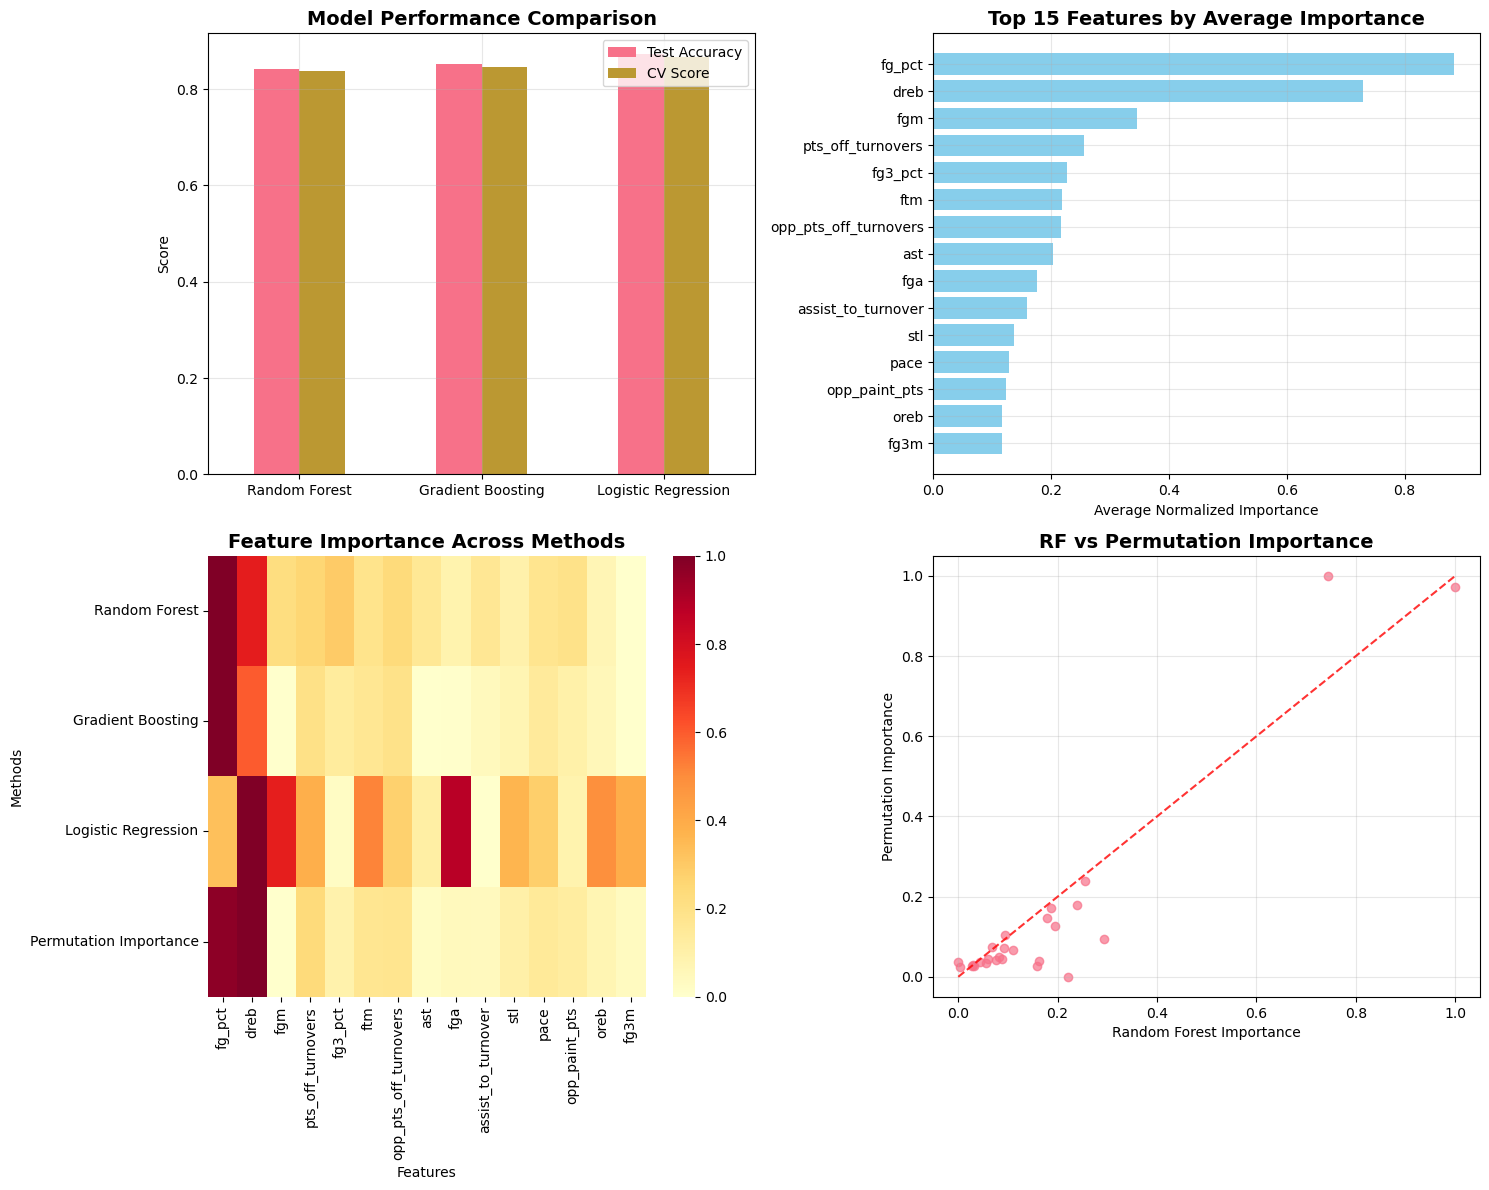

In [55]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 12))

# Model performance comparison
performance_data = pd.DataFrame(results).T
performance_data.plot(kind='bar', ax=ax1, rot=0)
ax1.set_title('Model Performance Comparison', fontsize=14, fontweight='bold')
ax1.set_ylabel('Score')
ax1.legend(['Test Accuracy', 'CV Score'])
ax1.grid(True, alpha=0.3)

# Top Features by Average Importance

top_15_features = importance_df.head(15)
ax2.barh(range(len(top_15_features)), top_15_features['Average'], color='skyblue')
ax2.set_yticks(range(len(top_15_features)))
ax2.set_yticklabels(top_15_features.index, fontsize=10)
ax2.set_xlabel('Average Normalized Importance')
ax2.set_title('Top 15 Features by Average Importance', fontsize=14, fontweight='bold')
ax2.invert_yaxis()
ax2.grid(True, alpha=0.3)

# Feature Importance Heatmap

methods_to_plot = ['Random Forest', 'Gradient Boosting', 'Logistic Regression', 'Permutation Importance']
heatmap_data = top_15_features[methods_to_plot].T

sns.heatmap(heatmap_data, annot=False, cmap='YlOrRd', cbar=True, ax=ax3)
ax3.set_title('Feature Importance Across Methods', fontsize=14, fontweight='bold')
ax3.set_xlabel('Features')
ax3.set_ylabel('Methods')

# Random Forest vs Permutation Importance

ax4.scatter(importance_df['Random Forest'], importance_df['Permutation Importance'], alpha=0.7)
ax4.plot([0, 1], [0, 1], 'r--', alpha=0.8)
ax4.set_xlabel('Random Forest Importance')
ax4.set_ylabel('Permutation Importance')
ax4.set_title('RF vs Permutation Importance', fontsize=14, fontweight='bold')
ax4.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

### Feature Rankings Consistency Analysis


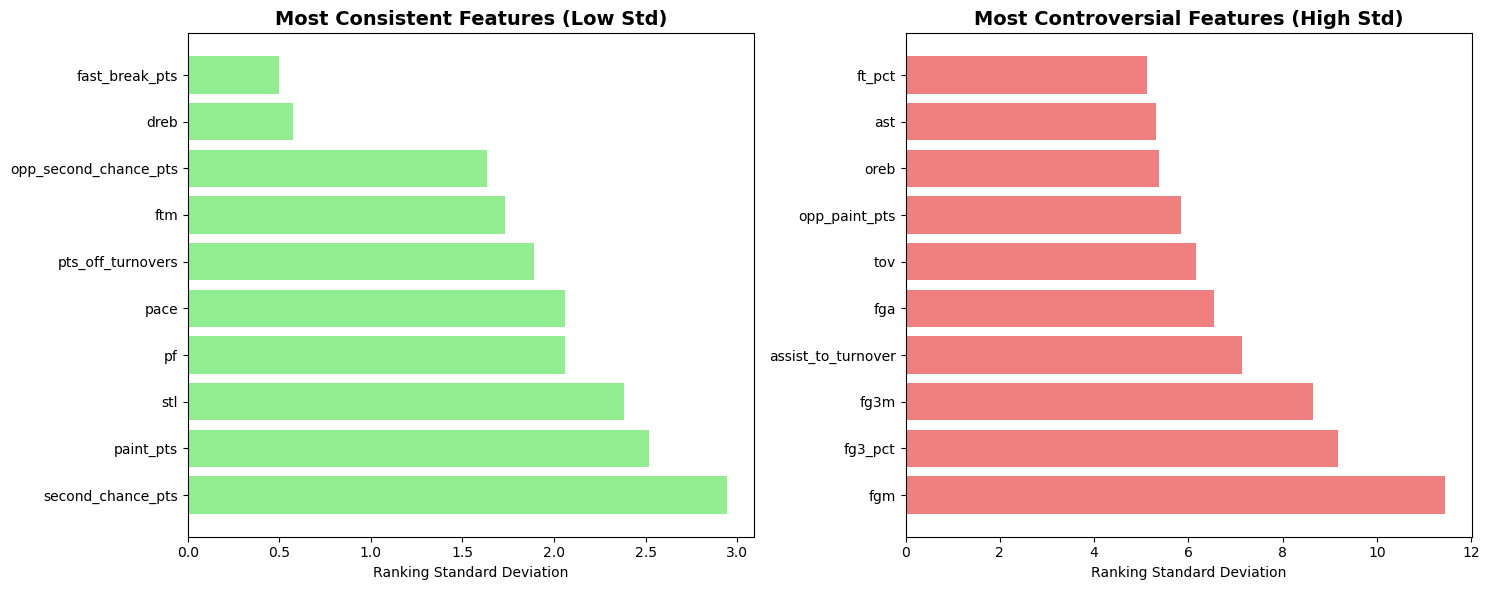

In [56]:
ranking_std = ranking_df[methods_to_plot].std(axis=1).sort_values()

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Most consistent features
most_consistent = ranking_std.head(10)
ax1.barh(range(len(most_consistent)), most_consistent, color='lightgreen')
ax1.set_yticks(range(len(most_consistent)))
ax1.set_yticklabels(most_consistent.index)
ax1.set_xlabel('Ranking Standard Deviation')
ax1.set_title('Most Consistent Features (Low Std)', fontsize=14, fontweight='bold')
ax1.invert_yaxis()

# Most controversial features
most_controversial = ranking_std.tail(10)
ax2.barh(range(len(most_controversial)), most_controversial, color='lightcoral')
ax2.set_yticks(range(len(most_controversial)))
ax2.set_yticklabels(most_controversial.index)
ax2.set_xlabel('Ranking Standard Deviation')
ax2.set_title('Most Controversial Features (High Std)', fontsize=14, fontweight='bold')
ax2.invert_yaxis()

plt.tight_layout()
plt.show()


## Key Findings and Insights


In [59]:
performance_summary = pd.DataFrame(results).T
print("MODEL PERFORMANCE SUMMARY")
print("=" * 40)
print(performance_summary.round(4))

MODEL PERFORMANCE SUMMARY
                     accuracy  cv_score
Random Forest          0.8425    0.8375
Gradient Boosting      0.8514    0.8470
Logistic Regression    0.8723    0.8666


In [60]:
print(f"\nTOP 10 MOST PREDICTIVE FEATURES")
print("=" * 40)
top_10 = importance_df.head(10)

for i, (feature, row) in enumerate(top_10.iterrows(), 1):
    print(f"{i:2d}. {feature:<25} (Score: {row['Average']:.3f})")


TOP 10 MOST PREDICTIVE FEATURES
 1. fg_pct                    (Score: 0.884)
 2. dreb                      (Score: 0.730)
 3. fgm                       (Score: 0.345)
 4. pts_off_turnovers         (Score: 0.255)
 5. fg3_pct                   (Score: 0.228)
 6. ftm                       (Score: 0.218)
 7. opp_pts_off_turnovers     (Score: 0.217)
 8. ast                       (Score: 0.203)
 9. fga                       (Score: 0.175)
10. assist_to_turnover        (Score: 0.159)


In [62]:
print(f"\nFEATURE RANKINGS ACROSS METHODS (Top 10)")
print("=" * 55)
top_10_ranking = ranking_df.head(10)
methods = ['Random Forest', 'Gradient Boosting', 'Logistic Regression', 'Permutation Importance']

print(f"{'Feature':<25} {'RF':<4} {'GB':<4} {'LR':<4} {'PI':<4} {'Avg':<4}")
print("-" * 55)
for feature, row in top_10_ranking.iterrows():
    rf_rank = int(row['Random Forest'])
    gb_rank = int(row['Gradient Boosting']) 
    lr_rank = int(row['Logistic Regression'])
    pi_rank = int(row['Permutation Importance'])
    avg_rank = int(row['Average'])
    print(f"{feature:<25} {rf_rank:<4} {gb_rank:<4} {lr_rank:<4} {pi_rank:<4} {avg_rank:<4}")


FEATURE RANKINGS ACROSS METHODS (Top 10)
Feature                   RF   GB   LR   PI   Avg 
-------------------------------------------------------
fg_pct                    1    1    9    2    1   
dreb                      2    2    1    1    2   
fgm                       6    22   3    26   3   
pts_off_turnovers         4    3    7    3    4   
fg3_pct                   3    7    24   9    5   
ftm                       8    5    4    5    6   
opp_pts_off_turnovers     5    4    11   4    7   
ast                       11   18   17   24   8   
fga                       15   16   2    14   9   
assist_to_turnover        10   12   26   17   10  


# Strategic Insights

In [63]:
print(f"\nSTRATEGIC INSIGHTS")
print("=" * 40)

ranking_std = ranking_df[methods].std(axis=1)
most_consistent = ranking_std.head(5)

print("Most reliable predictors (consistent across methods):")
for i, (feature, std_val) in enumerate(most_consistent.items(), 1):
    avg_rank = int(ranking_df.loc[feature, 'Average'])
    avg_score = importance_df.loc[feature, 'Average']
    print(f"  {i}. {feature:<20} (Rank: {avg_rank}, Score: {avg_score:.3f})")



STRATEGIC INSIGHTS
Most reliable predictors (consistent across methods):
  1. fg_pct               (Rank: 1, Score: 0.884)
  2. dreb                 (Rank: 2, Score: 0.730)
  3. fgm                  (Rank: 3, Score: 0.345)
  4. pts_off_turnovers    (Rank: 4, Score: 0.255)
  5. fg3_pct              (Rank: 5, Score: 0.228)


In [66]:
# Categories of important features
offensive_features = ['fg_pct', 'fg3_pct', 'ft_pct', 'ast', 'oreb', 'fast_break_pts', 'paint_pts']
defensive_features = ['stl', 'blk', 'dreb', 'opp_pts_off_turnovers', 'opp_second_chance_pts']
efficiency_features = ['assist_to_turnover', 'tov', 'pace']

In [67]:
print(f"\nFeature category analysis:")
for category, features in [('Offensive', offensive_features), 
                          ('Defensive', defensive_features), 
                          ('Efficiency', efficiency_features)]:
    category_importance = importance_df.loc[
        importance_df.index.intersection(features), 'Average'
    ].mean()
    print(f"  {category} metrics avg importance: {category_importance:.3f}")



Feature category analysis:
  Offensive metrics avg importance: 0.228
  Defensive metrics avg importance: 0.238
  Efficiency metrics avg importance: 0.118


In [68]:
importance_df.to_csv('basketball_feature_importance_detailed.csv')
ranking_df.to_csv('basketball_feature_rankings.csv')
pd.DataFrame(results).T.to_csv('basketball_model_performance.csv')

print("Analysis complete! Results exported to CSV files:")
print("- basketball_feature_importance_detailed.csv")
print("- basketball_feature_rankings.csv") 
print("- basketball_model_performance.csv")

# Create summary report
summary_report = {
    'Top_5_Features': list(importance_df.head(5).index),
    'Best_Model': max(results.keys(), key=lambda x: results[x]['cv_score']),
    'Average_CV_Score': np.mean([results[model]['cv_score'] for model in results]),
    'Feature_Count': len(feature_names),
    'Sample_Size': len(X)
}

print(f"\nQuick Summary:")
for key, value in summary_report.items():
    print(f"{key}: {value}")

Analysis complete! Results exported to CSV files:
- basketball_feature_importance_detailed.csv
- basketball_feature_rankings.csv
- basketball_model_performance.csv

Quick Summary:
Top_5_Features: ['fg_pct', 'dreb', 'fgm', 'pts_off_turnovers', 'fg3_pct']
Best_Model: Logistic Regression
Average_CV_Score: 0.8503594730415681
Feature_Count: 26
Sample_Size: 68620
